In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Printf
using JLD2

  Activating environment at `~/devel/HW1_S23_solutions/lts_notebooks/Project.toml`


## Q2 (20 pts): Augmented Lagrangian Quadratic Program Solver

Here we are going to use the augmented lagrangian method described [here in a video](https://www.youtube.com/watch?v=0x0JD5uO_ZQ), with [the corresponding pdf here](https://github.com/Optimal-Control-16-745/lecture-notebooks-2022/blob/main/misc/AL_tutorial.pdf) to solve the following problem:

$$\begin{align}
\min_x \quad & \frac{1}{2}x^TQx + q^Tx \\ 
\mbox{s.t.}\quad &  Ax -b = 0 \\ 
&  Gx - h \leq 0 
\end{align}$$
where the cost function is described by $Q \in \mathbb{R}^{n \times n}$, $q \in \mathbb{R}^n$, an equality constraint is described by $A \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, and an inequality constraint is described by $G \in \mathbb{R}^{p \times n}$ and $h \in \mathbb{R}^p$.


By introducing a dual variable $\lambda \in \mathbb{R}^m$ for the equality constraint, and $\mu \in \mathbb{R}^p$ for the inequality constraint, we have the following KKT conditions for optimality:

$$\begin{align}
Qx + q + A^T\lambda + G^T \mu &= 0 \quad \quad \text{stationarity}\\ 
Ax-b&= 0 \quad \quad \text{primal feasibility} \\ 
Gx-h&\leq 0 \quad \quad \text{primal feasibility} \\ 
\mu &\geq 0 \quad \quad \text{dual feasibility} \\ 
\mu \circ (Gx - h) &= 0 \quad \quad \text{complementarity}
  \end{align}$$
  where $\circ$ is element-wise multiplication.  

In [36]:
# NOTE: this is the template the students will get 

"""
The data for the QP is stored in `qp` the following way:
    @load joinpath(@__DIR__, "qp_data.jld2") qp 

which is a NamedTuple, where
    Q, q, A, b, G, h = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

contains all of the problem data you will need for the QP.

Your job is to make the following function 
    
    x, λ, μ = solve_qp(qp)

You can use (or not use) any of the additional functions:
"""
function cost(qp::NamedTuple, x::Vector)::Real
    0.5*x'*qp.Q*x + dot(qp.q,x)
end
function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A*x - qp.b 
end
function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G*x - qp.h
end

function mask_matrix(qp::NamedTuple, x::Vector, μ::Vector, ρ::Real)::Matrix
    error("not implemented")
end
function augmented_lagrangian(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector, ρ::Real)::Real
    error("not implemented")
end
function logging(qp::NamedTuple, main_iter::Int, AL_gradient::Vector, x::Vector, λ::Vector, μ::Vector, ρ::Real)
    # TODO: stationarity norm
    stationarity_norm = 0.0
    @printf("%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e\n",
          main_iter, stationarity_norm, norm(AL_gradient), maximum(h_ineq(qp,x)),
          norm(c_eq(qp,x),Inf), abs(dot(μ,h_ineq(qp,x))), ρ)
end
function solve_qp(qp)
    x = zeros(length(qp.q))
    λ = zeros(length(qp.b))
    μ = zeros(length(qp.h))
    
    @printf "iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ\n"
    @printf "----------------------------------------------------------------\n"
    
    for main_iter = 1:20  
        logging(qp, main_iter, zeros(1), x, λ, μ, 0.0)
        
        if true 
            return x, λ, μ
        end
    end
    error("qp solver did not converge")
end
let 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp)
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00   4.38e+00   6.49e+00   0.00e+00  0e+00


([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0])

In [37]:
# NOTE: here is the solution

"""
The data for the QP is stored in `qp` the following way:
    @load joinpath(@__DIR__, "qp_data.jld2") qp 

which is a NamedTuple, where
    Q, q, A, b, G, h = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

contains all of the problem data you will need for the QP.

Your job is to make the following function 
    
    x, λ, μ = solve_qp(qp)

You can use (or not use) any of the following functions:
"""
function cost(qp::NamedTuple, x::Vector)::Real
    0.5*x'*qp.Q*x + dot(qp.q,x)
end
function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A*x - qp.b 
end
function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G*x - qp.h
end
function kkt_conditions(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector)::Vector
    return [
        qp.A'*λ + qp.G'*μ + qp.Q*x + qp.q; # stationarity
        c_eq(qp,x);
        (h_ineq(qp,x) .* μ)
    ]
end
function mask_matrix(qp::NamedTuple, x::Vector, μ::Vector, ρ::Real)::Matrix
    h = h_ineq(qp,x)
    Iρ = zeros(length(μ), length(μ))
    for i = 1:length(μ)
        if ((h[i] < 0) && (μ[i] ==0))
            Iρ[i,i]=0
        else
            Iρ[i,i]=ρ
        end
    end
    return Iρ
end
function augmented_lagrangian(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector, ρ::Real)::Real
    h = h_ineq(qp,x)
    c = c_eq(qp,x)
    Iρ = mask_matrix(qp, x, μ, ρ)
    cost(qp,x) + λ'*c + μ'*h + 0.5*ρ*c'c + 0.5*h'*Iρ*h
end
function logging(qp, main_iter, al_gradient, x, λ, μ, ρ)
    stationarity = norm(qp.A'*λ + qp.G'*μ + qp.Q*x + qp.q)
    @printf("%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e\n",
          main_iter, stationarity, norm(al_gradient), maximum(h_ineq(qp,x)),
          norm(c_eq(qp,x),Inf), abs(dot(μ,h_ineq(qp,x))), ρ)
end
function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    x = zeros(length(qp.q))
    λ = zeros(length(qp.b))
    μ = zeros(length(qp.h))
    ρ = 1.0 
    ϕ = 10.0
    
    if verbose
        @printf "iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ\n"
        @printf "----------------------------------------------------------------\n"
    end
    for main_iter = 1:max_iters
        g = FD.gradient(_x->augmented_lagrangian(qp,_x,λ,μ,ρ), x)
        if norm(g) < 1e-6 
            λ += ρ*c_eq(qp, x)
            μ = max.(0, μ + ρ*h_ineq(qp,x))
            ρ *= ϕ
        else
            H = FD.hessian(_x->augmented_lagrangian(qp,_x,λ,μ,ρ), x)
            x += -H\g
        end
        if verbose
            logging(qp, main_iter, g, x, λ, μ, ρ)
        end
        
        if (maximum(h_ineq(qp,x)) < tol) && (norm(c_eq(qp,x),Inf) < tol)
            if verbose 
                @info "success"
            end
            return x, λ, μ
        end  
    end
    error("QP solver failed to converge")
end

solve_qp (generic function with 1 method)

In [38]:
using Test 
@testset "qp solver" begin 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp)
    
    @load joinpath(@__DIR__, "qp_solutions.jld2") qp_solutions
    @test norm(x - qp_solutions.x,Inf)<1e-3;
    @test norm(λ - qp_solutions.λ,Inf)<1e-3;
    @test norm(μ - qp_solutions.μ,Inf)<1e-3;
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   5.60e+01   1.55e+00   1.31e+00   0.00e+00  1e+00
  2   0.00e+00   4.83e+00   5.51e-01   1.27e+00   0.00e+00  1e+00
  3   0.00e+00   5.25e-15   5.51e-01   1.27e+00   4.59e-01  1e+01
  4   0.00e+00   4.92e+01   2.56e-02   3.07e-01   4.94e-02  1e+01
  5   0.00e+00   3.32e-14   2.56e-02   3.07e-01   1.05e-02  1e+02
  6   0.00e+00   8.87e+01   6.84e-03   1.35e-02   4.55e-04  1e+02
  7   0.00e+00   2.68e-13   6.84e-03   1.35e-02   7.94e-03  1e+03
  8   0.00e+00   4.28e+01   6.84e-02   1.55e-04   1.40e-04  1e+03
  9   0.00e+00   2.13e+02   3.64e-05   1.62e-04   1.17e-04  1e+03
 10   0.00e+00   3.12e-12   3.64e-05   1.62e-04   1.06e-04  1e+04
 11   0.00e+00   5.30e+00  -5.61e-09   2.05e-08   1.14e-08  1e+04
 12   0.00e+00   3.11e-11  -5.61e-09   2.05e-08   1.14e-08  1e+05
 13   0.00e+00   5.21e-03  -1.57e-13   3.92e-13   1.88e-13  1e+05
Test Summary: 

[ Info: success


Test.DefaultTestSet("qp solver", Any[], 3, false, false)

# Simulating a Falling Brick with QP's
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Augmented Lagrangian method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \lambda \\ \text{ where } M = mI_{2\times 2}, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\lambda \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.

We can discretize the dynamics with backward Euler:
$$ \begin{align} \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot \begin{bmatrix} \frac{1}{m} J^T \lambda_{k+1} - g \\ v_{k+1} \end{bmatrix} \end{align} $$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\lambda_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\lambda_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (a): QP formulation (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.

$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} \\
    &\text{subject to} && -J(q_k + \Delta t \cdot v_{k+1}) \leq 0 \\
\end{align} $$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

**SOLUTION**: \
Lagrangian:
$$ \mathcal{L} = \frac{1}{2} v_{k+1}^T M v_{k+1} + v_{k+1}^T M (\Delta t \cdot g - v_k) - \lambda J(q_k + \Delta t \cdot v_{k+1}) $$

KKT Conditions:
$$ \begin{align}
    M v_{k+1} + M(hg - v_k) - \lambda h J^T &= 0 \\
    -J(q_k + h v_{k+1}) &\le 0 \\
    \lambda &\ge 0 \\
    \lambda J(q_k + h v_{k+1}) &= 0 \\
\end{align} $$

Solving the first equation for $v_{k+1}$ we get the backward Euler velocity dynamics:
$$ v_{k+1} = v_k + \Delta t \cdot \left(\frac{1}{m} \lambda J^T - g\right) $$

Substituting $q_k = q_{k+1} - \Delta t \cdot v_{k+1}$ into the constraint and complimentarity condition we get the other 2 contact constraints:
$$ 
J(q_{k+1}) \geq 0 \\
\lambda J(q_{k+1}) = 0 
$$

In [39]:
function brick_simulation_qp(q, v; mass = 1, h = 0.01)
    
    # TODO: fill in the QP problem data for a simulation step 
    M = mass*diagm(ones(2))
    g = [0, 9.81]
    J = [0 1]
    
    qp = (
        Q = M, 
        q = M*(h*g - v),
        A = zeros(0,2),
        b = zeros(0),
        G = -J*h,
        h = J*q
    )
end

brick_simulation_qp (generic function with 1 method)

In [40]:
let 
    
    q = randn(2)
    v = randn(2)
    
    qp = brick_simulation_qp(q,v)
    
    # check all the types to make sure they're right
    qp.Q::Matrix{Float64}
    qp.q::Vector{Float64}
    qp.A::Matrix{Float64}
    qp.b::Vector{Float64}
    qp.G::Matrix{Float64}
    qp.h::Vector{Float64}
    
end

1-element Vector{Float64}:
 2.069044453614034

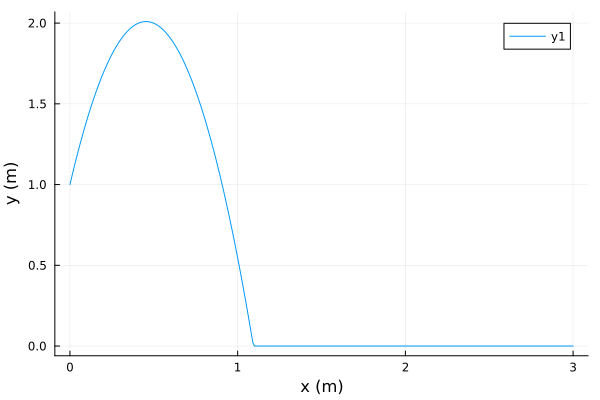

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8716


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("brick" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x72, 0x69, 0x63, 0x6b], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8716))

In [42]:
include(joinpath(@__DIR__, "animate_brick.jl"))
let 
    
    dt = 0.01 
    T = 3.0 
    
    t_vec = 0:dt:T
    N = length(t_vec)
    
    qs = [zeros(2) for i = 1:N]
    vs = [zeros(2) for i = 1:N]
    
    qs[1] = [0, 1.0]
    vs[1] = [1, 4.5]
    
    for i = 1:(N-1)
        qp = brick_simulation_qp(qs[i],vs[i])
        vs[i+1],_,_=solve_qp(qp; verbose = false)
        qs[i+1] = qs[i] + dt*vs[i+1]
    end
    
    xs = [q[1] for q in qs]
    ys = [q[2] for q in qs]
    
    display(plot(xs, ys, ylabel = "y (m)", xlabel = "x (m)"))
    
    animate_brick(qs)
    
    # NOTE: add testing stuff here 
    
end